In [137]:
import tensorflow as tf
import keras
from keras import backend as bk


from scipy.integrate import ode
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import random as rdm

### ANN Model

In [148]:
class Hamiltonian_model:
    
    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(4,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l2=tf.keras.layers.Dense(16,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.l3=tf.keras.layers.Dense(16,kernel_initializer=xavier,activation=tf.nn.tanh)
        self.out=tf.keras.layers.Dense(1,kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adagrad(learning_rate=0.001)
        
    # Running the model
    
    def run(self, X):
        boom = self.l1(X)
        boom1 = self.l2(boom)
        boom2 = self.l3(boom1)
        boom3 = self.out(boom2)
        return boom3
    
    def get_loss(self, Y, X):
        
        with tf.GradientTape() as tape:
            tape.watch(Y)
            boom = self.l1(Y)
            boom1 = self.l2(boom)
            boom2 = self.l3(boom1)
            boom3 = self.out(boom2)
            g = tape.gradient(boom3, Y)

        loss = tf.constant(0.)
        c1=1.
        c2=1.
        c3=1.
        H_predict = self.run(Y)
        
        for i,j in zip(Y,g):

            loss_i = c1*(i[2]-j[1])**(2) + c2*(i[3]+j[1])**(2) + c3*(H_predict - (i[1]**(2)/2 - tf.math.cos(i[0])))**(2)

            loss = loss + loss_i

        return loss
    
    def get_grad(self, Y, X):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            tape.watch(self.l2.variables)
            tape.watch(self.l3.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(Y, X)
            g = tape.gradient(L, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]])
        return g

    # perform gradient descent
    
    def network_learn(self, Y, X):
        g = self.get_grad(Y, X)
        self.train_op.apply_gradients(zip(g, [self.l1.variables[0],self.l1.variables[1],self.l2.variables[0],self.l2.variables[1],self.l3.variables[0],self.l3.variables[1],self.out.variables[0],self.out.variables[1]]))



### Non-linear Pendulum
#### Parameters

In [161]:
N_Sample = 10000
d0, t0 = [[rdm.randrange(-600, 600, 1)*0.01, rdm.randrange(-100, 100, 1)*0.01] for i in range(N_Sample)], 0
t1 = 2
dt = 0.005

def Ham(t, y):
    return [y[1], -mt.sin(y[0])]

#### Simulating the Training Data

In [162]:
training_set = []

for i in range(len(d0)):
    r = ode(Ham).set_integrator('zvode', method='bdf')
    r.set_initial_value(d0[i], t0)
    trajectory = []

    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)
        q = (r.integrate(r.t)[0]).real
        p = (r.integrate(r.t)[1]).real
        qdot = (r.integrate(r.t)[1]).real
        pdot = (mt.sin(r.integrate(r.t)[0])).real
        trajectory.append([q, p, qdot, pdot])


    training_set.append(trajectory)

C:\Users\valpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  import sys
C:\Users\valpe\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


#### Plotting the Training Set

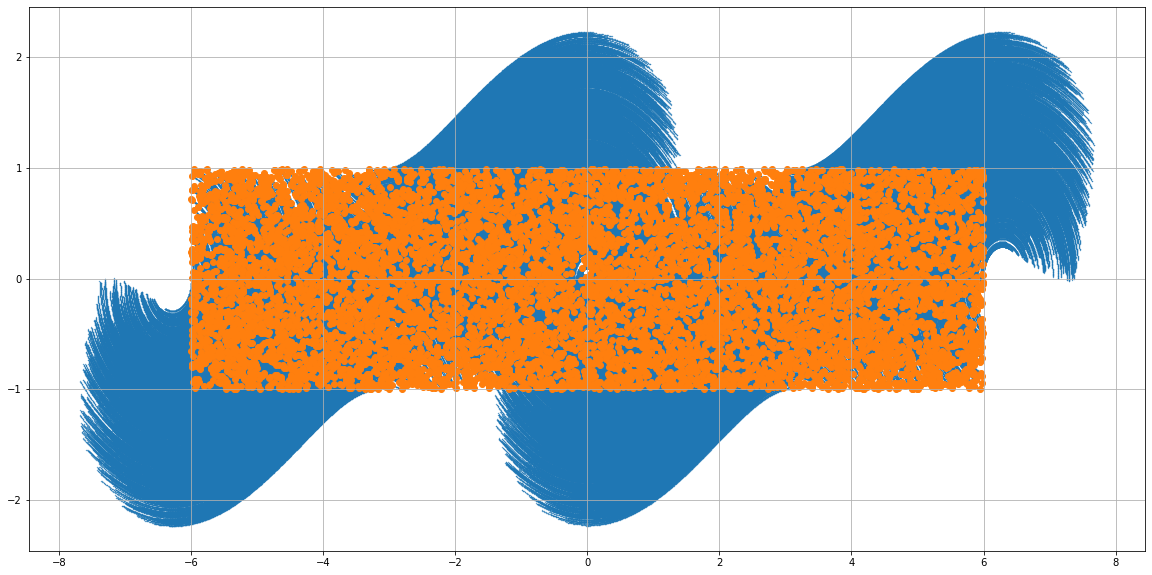

In [163]:
q0, p0 = np.array(d0).T

Q=[]
for q in range(len(training_set[:])):
    QQ = []
    for qq in training_set[:][q]:
        QQ.append(qq[0])
    Q.append(QQ)
P=[]
for p in range(len(training_set[:])):
    PP = []
    for pp in training_set[:][p]:
        PP.append(pp[1])
    P.append(PP)

fig = plt.figure(figsize=(20,10))
ax = fig.gca()
plt.scatter(Q, P, s=0.1)
plt.scatter(q0, p0)
plt.grid()
plt.show()

#### Preparing the Training set and the Model

In [164]:
train = tf.cast(tf.constant(training_set), float)
Model = Hamiltonian_model()
train[0].shape

TensorShape([401, 4])

#### Training and evaluating the model

In [165]:
for i in range(len(train)):
    Model.network_learn(train[i], train[i])
    if i%10==0:
        print((i/len(train))*100, '%')
        print('Loss:', tf.math.reduce_mean(Model.get_loss(train[i], train[i])).numpy())

0.0 %
Loss: 1240.2236
0.1 %
Loss: 1939.0869
0.2 %
Loss: 875.72046
0.3 %
Loss: 379.78955
0.4 %
Loss: 1074.8843
0.5 %
Loss: 448.96646
0.6 %
Loss: 1038.7305
0.7000000000000001 %
Loss: 447.18747
0.8 %
Loss: 687.67566
0.8999999999999999 %
Loss: 255.03133
1.0 %
Loss: 492.96747
1.0999999999999999 %
Loss: 555.2201
1.2 %
Loss: 611.29926
1.3 %
Loss: 652.9172
1.4000000000000001 %
Loss: 1183.4326
1.5 %
Loss: 297.41495
1.6 %
Loss: 522.5545
1.7000000000000002 %
Loss: 619.8744
1.7999999999999998 %
Loss: 528.5862
1.9 %
Loss: 749.2979
2.0 %
Loss: 597.1462
2.1 %
Loss: 875.62744
2.1999999999999997 %
Loss: 1496.7567
2.3 %
Loss: 718.61346
2.4 %
Loss: 569.775
2.5 %
Loss: 482.1058
2.6 %
Loss: 490.92734
2.7 %
Loss: 598.7521
2.8000000000000003 %
Loss: 510.35406
2.9000000000000004 %
Loss: 445.0431
3.0 %
Loss: 996.9049
3.1 %
Loss: 714.8513
3.2 %
Loss: 707.2908
3.3000000000000003 %
Loss: 1492.2281
3.4000000000000004 %
Loss: 1079.8286
3.5000000000000004 %
Loss: 1005.44476
3.5999999999999996 %
Loss: 601.87085
3.699

Loss: 315.47006
31.3 %
Loss: 1354.1577
31.4 %
Loss: 444.1883
31.5 %
Loss: 274.24207
31.6 %
Loss: 608.87286
31.7 %
Loss: 690.56006
31.8 %
Loss: 1050.6804
31.900000000000002 %
Loss: 354.85162
32.0 %
Loss: 949.6338
32.1 %
Loss: 395.28348
32.2 %
Loss: 348.7782
32.300000000000004 %
Loss: 247.85109
32.4 %
Loss: 986.4022
32.5 %
Loss: 1861.7344
32.6 %
Loss: 183.12149
32.7 %
Loss: 225.11768
32.800000000000004 %
Loss: 165.69989
32.9 %
Loss: 453.65262
33.0 %
Loss: 586.0906
33.1 %
Loss: 1728.079
33.2 %
Loss: 927.59326
33.300000000000004 %
Loss: 144.0218
33.4 %
Loss: 209.41556
33.5 %
Loss: 758.99384
33.6 %
Loss: 1224.6738
33.7 %
Loss: 302.74982
33.800000000000004 %
Loss: 349.12067
33.900000000000006 %
Loss: 381.45932
34.0 %
Loss: 158.21121
34.1 %
Loss: 209.97337
34.2 %
Loss: 649.8555
34.300000000000004 %
Loss: 732.6312
34.4 %
Loss: 681.9239
34.5 %
Loss: 165.26431
34.599999999999994 %
Loss: 269.80713
34.699999999999996 %
Loss: 108.395065
34.8 %
Loss: 691.83954
34.9 %
Loss: 220.79836
35.0 %
Loss: 467

62.3 %
Loss: 1577.3544
62.4 %
Loss: 376.92917
62.5 %
Loss: 1789.7637
62.6 %
Loss: 49.526585
62.7 %
Loss: 860.3089
62.8 %
Loss: 768.9018
62.9 %
Loss: 869.3312
63.0 %
Loss: 122.58398
63.1 %
Loss: 930.9322
63.2 %
Loss: 122.43947
63.3 %
Loss: 87.96707
63.4 %
Loss: 364.2452
63.5 %
Loss: 320.0165
63.6 %
Loss: 428.44965
63.7 %
Loss: 90.612144
63.800000000000004 %
Loss: 670.17535
63.9 %
Loss: 159.4762
64.0 %
Loss: 272.97574
64.1 %
Loss: 1286.8439
64.2 %
Loss: 184.17467
64.3 %
Loss: 514.21234
64.4 %
Loss: 109.09626
64.5 %
Loss: 134.82915
64.60000000000001 %
Loss: 710.4724
64.7 %
Loss: 129.06456
64.8 %
Loss: 219.87509
64.9 %
Loss: 1751.026
65.0 %
Loss: 1182.3286
65.10000000000001 %
Loss: 110.19429
65.2 %
Loss: 443.49808
65.3 %
Loss: 900.96643
65.4 %
Loss: 737.71545
65.5 %
Loss: 111.33193
65.60000000000001 %
Loss: 150.37817
65.7 %
Loss: 104.28238
65.8 %
Loss: 736.80994
65.9 %
Loss: 493.76135
66.0 %
Loss: 108.052246
66.10000000000001 %
Loss: 414.67258
66.2 %
Loss: 189.15839
66.3 %
Loss: 921.58325


Loss: 168.63342
94.89999999999999 %
Loss: 1361.9618
95.0 %
Loss: 184.75449
95.1 %
Loss: 215.81009
95.19999999999999 %
Loss: 90.60142
95.3 %
Loss: 327.14526
95.39999999999999 %
Loss: 1204.7882
95.5 %
Loss: 744.31866
95.6 %
Loss: 765.78156
95.7 %
Loss: 447.35272
95.8 %
Loss: 117.0475
95.89999999999999 %
Loss: 151.42355
96.0 %
Loss: 109.60477
96.1 %
Loss: 1566.3881
96.2 %
Loss: 31.712698
96.3 %
Loss: 125.53219
96.39999999999999 %
Loss: 179.82913
96.5 %
Loss: 74.71721
96.6 %
Loss: 85.30707
96.7 %
Loss: 808.5065
96.8 %
Loss: 413.98453
96.89999999999999 %
Loss: 905.2881
97.0 %
Loss: 173.17734
97.1 %
Loss: 314.2878
97.2 %
Loss: 769.9389
97.3 %
Loss: 277.1109
97.39999999999999 %
Loss: 248.2921
97.5 %
Loss: 583.3588
97.6 %
Loss: 923.9837
97.7 %
Loss: 522.73895
97.8 %
Loss: 532.22894
97.89999999999999 %
Loss: 839.7699
98.0 %
Loss: 91.78407
98.1 %
Loss: 1076.6643
98.2 %
Loss: 209.8476
98.3 %
Loss: 678.32465
98.4 %
Loss: 676.47784
98.5 %
Loss: 58.602066
98.6 %
Loss: 190.26437
98.7 %
Loss: 695.5945

In [166]:
H = []
for i in range(-300, 300):
    h=[]
    print(i)
    for j in range(-150, 150):
        h.append(Model.run(tf.constant([[i*0.01, j*0.01, 0., 0.]]))[0][0])
    H.append(h)

-300
-299
-298
-297
-296
-295
-294
-293
-292
-291
-290
-289
-288
-287
-286
-285
-284
-283
-282
-281
-280
-279
-278
-277
-276
-275
-274
-273
-272
-271
-270
-269
-268
-267
-266
-265
-264
-263
-262
-261
-260
-259
-258
-257
-256
-255
-254
-253
-252
-251
-250
-249
-248
-247
-246
-245
-244
-243
-242
-241
-240
-239
-238
-237
-236
-235
-234
-233
-232
-231
-230
-229
-228
-227
-226
-225
-224
-223
-222
-221
-220
-219
-218
-217
-216
-215
-214
-213
-212
-211
-210
-209
-208
-207
-206
-205
-204
-203
-202
-201
-200
-199
-198
-197
-196
-195
-194
-193
-192
-191
-190
-189
-188
-187
-186
-185
-184
-183
-182
-181
-180
-179
-178
-177
-176
-175
-174
-173
-172
-171
-170
-169
-168
-167
-166
-165
-164
-163
-162
-161
-160
-159
-158
-157
-156
-155
-154
-153
-152
-151
-150
-149
-148
-147
-146
-145
-144
-143
-142
-141
-140
-139
-138
-137
-136
-135
-134
-133
-132
-131
-130
-129
-128
-127
-126
-125
-124
-123
-122
-121
-120
-119
-118
-117
-116
-115
-114
-113
-112
-111
-110
-109
-108
-107
-106
-105
-104
-103
-102
-101


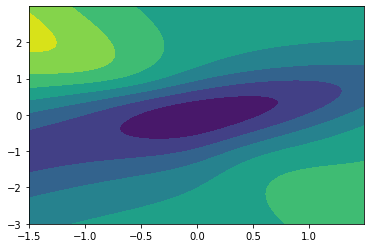

In [167]:
x = np.arange(-3, 3, 0.01)
y = np.arange(-1.5, 1.5, 0.01)
z = np.array(H)
plt.contourf(y,x,z)
plt.show()

-------------------------------
-------------------------------
-------------------------------

In [14]:
#TRAINING AND PREDICTIONS
Y = tf.constant([[0.,3.,1.,0.],[0.,1.,1.,1,],[1.,2.,2.,0.],[0.,3.,1.,0.],[0.,1.,1.,1.],[1.,2.,2.,0.]]) 
My_model = my_model()
My_model.network_learn(Y, Y)

In [45]:
My_model.network_learn(Y, Y)

In [46]:
My_model.run(tf.constant([[0.,1.,1.,1.]]))

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.0565188]], dtype=float32)>

----------------------------------------------------------------
----------------------------------------------------------------
----------------------------------------------------------------